<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este projeto tem o intuito de estudar Modelos de Séries Temporais para previsão de informações sobre a temperatura na Índia. </i>       
</p>  

https://www.kaggle.com/code/obougacha/a-guide-for-time-series-analysis-arima-sarima#Conclusion-and-discussion

https://www.kaggle.com/code/ahmedayman101/timeserieseval-sarima-var-fbprophit-xgboost-lstm

https://www.kaggle.com/code/jurk06/auto-arima-on-multivariate-time-series

https://www.kaggle.com/code/georgyzubkov/daily-climate-in-delhi-arima-with-timeseries

# <font color='red' style='font-size: 40px;'> Problemática </font>
<hr style='border: 2px solid red;'>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i>  Este projeto tem o intuito de estudar Modelos de Séries Temporais para previsão de informações sobre a temperatura na Índia.


</i> 
</p>  

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> 
</i> 
</p>  


# <font color='red' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid red;'>

In [1]:
## Bibliotecas De Manipulação de Dados e Visualização
import pandas as pd 
import geopandas as gpd
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
import itertools
import plotly.express as px
import plotly.io as pio
from IPython.display import display, Image

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm


# Bibliotecas de Manipulação de Tempo
import time
import datetime

# Bibliotecas de Métricas de Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# Parâmetros de Otimização
import warnings
%matplotlib inline
sns.set()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# <font color='red' style='font-size: 40px;'> Funções </font>
<hr style='border: 2px solid red;'>

In [2]:
def analisa_estacionaridade(series):
    for test_name, test in {"Adfuller": adfuller, "KPSS": kpss}.items():
        result = test(series.values)
        print(f'\033[34m{test_name}\033[0m')
        print('p-value: %.3f' % result[1]) #posição do p_value é a mesma para ambos testes (posição 1)

        # Os valores críticos estão na posição 4 na saída do Adfuller e na posição 3 do KPSS:
        critical_values = result[4] if test_name == "Adfuller" else result[3]
        critical_values = critical_values["5%"] # Vamos olhar apenas o teste com 95% de confiança

        check_adfuller = (test_name == "Adfuller") & (result[1] <= 0.05)  & (critical_values > result[0])
        check_kpss = (test_name == "KPSS") & (result[1] > 0.05)  & (critical_values > result[0])

        if (check_adfuller) | (check_kpss):
            print("\u001b[32mEstacionária com nível de confiança de 95%\u001b[0m")
        else:
            print("\x1b[31mNão estacionária com nível de confiança de 95%\x1b[0m")
        print("\n")

In [3]:
def plota_acf_pacf(series):
    fig, ax = plt.subplots(2,1, figsize = (12,5))
    fig = sm.graphics.tsa.plot_acf(series, lags=50, ax=ax[0], auto_ylims=True)
    fig = sm.graphics.tsa.plot_pacf(series, lags=50, ax=ax[1], auto_ylims=True)
    plt.tight_layout()
    plt.show()

In [4]:
def plota_histograma_boxplot_qq(variavel, df, titulo):
    mediana = df[variavel].median()
    media = round(df[variavel].mean(), 2)

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    # Histograma
    sns.histplot(data=df, x=variavel, bins=60, ax=axes[0], color='#1FB3E5', shrink=0.8)
    axes[0].axvline(x=mediana, ymax=0.75, color='#231F20', linestyle='-', label=f'Mediana = {mediana}')
    axes[0].axvline(x=media, ymax=0.75, color='#231F20', linestyle='--', label=f'Média = {media}')
    axes[0].set_title(f'Distribuição {titulo}', fontsize=14)
    axes[0].set_xlabel('Valores', fontsize=12)
    axes[0].set_ylabel('Frequência', fontsize=12)
    axes[0].legend(loc='best')
    axes[0].grid(False)
    axes[0].set_frame_on(False)

    # Boxplot
    sns.boxplot(data=df, x=variavel, ax=axes[1], color='#1FB3E5', orient='h')
    axes[1].set_title(f'Boxplot {titulo}', fontsize=14)
    axes[1].set_xlabel('Valores', fontsize=12)
    axes[1].grid(False)
    axes[1].set_frame_on(False)

    # QQ Plot
    stats.probplot(df[variavel].dropna(), dist="norm", plot=axes[2])
    axes[2].set_title(f'QQ Plot {titulo}', fontsize=14)
    axes[2].grid(False)
    axes[2].set_xlabel('Quantis Teóricos', fontsize=12)
    axes[2].set_ylabel('Quantis da Amostra', fontsize=12)

    plt.tight_layout()
    plt.show()


In [5]:
def ano_mes_dia(df):

    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day


In [8]:
def metricas(modelo, y_true, y_predict):

    mae = mean_absolute_error(y_predict, y_true)
    mse = mean_squared_error(y_predict, y_true)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_predict, y_true)
    metricas = pd.DataFrame(
        {
            'MAE':mae, 
            'RMSE':rmse, 
            'MAPE':mape,
            'modelo':modelo
        }, index = np.arange(1, 2))

    return metricas



# <font color='red' style='font-size: 40px;'> 1) Leitura do Dataset </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 1.1) Descrição das Variáveis </font>
<hr style='border: 2px solid green;'>

### 1.1.1) Cases

1. **Date:** Data

2. **meantemp:** Temperatura média medida por 3 intervalos de tempo no dia

3. **humidty:** Humidade (unidade: gramas de vapor/volume de ar por metro cúbico)

4. **wind_speed:** Velocidade do Vento

5. **meanpressure:** Pressão atmosférica

In [127]:
df_climate_train = pd.read_csv('./data/DailyDelhiClimateTrain.csv')
ano_mes_dia(df_climate_train)
df_climate_train = df_climate_train[['date', 'month', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]


df_climate_test = pd.read_csv('./data/DailyDelhiClimateTest.csv')
ano_mes_dia(df_climate_test)
df_climate_test = df_climate_test[['date', 'month', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]

# <font color='red' style='font-size: 40px;'> 2) Análise Exploratória </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 2.1) Como é a distribuição das variáveis ? </font>
<hr style='border: 2px solid green;'>

> 1. As distribuições parecem estáveis, de modo que não vemos valores tão extremos que nos levariam a achar que foi um erro

> 2. A Pressão Atmosférica apresenta um caso de valor negativo (está medida em ATM, então é impossível) e há um valor de 7679 que é muito diferente do resto da distribuição, portanto, pode-se considerá-lo um erro de medição

In [10]:
df_climate_train.describe(percentiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])

,month,year,meantemp,humidity,wind_speed,meanpressure
count,1462.00,1462.00,1462.00,1462.00,1462.00,1462.00
mean,6.52,2014.50,25.50,60.77,6.80,1011.10
std,3.45,1.12,7.35,16.77,4.56,180.23
min,1.00,2013.00,6.00,13.43,0.00,-3.04
1%,1.00,2013.00,9.95,22.22,0.00,994.20
5%,1.00,2013.00,12.51,29.00,0.93,996.83
10%,2.00,2013.00,14.62,36.21,1.62,998.14
20%,3.00,2013.00,17.62,47.25,2.91,1000.54
30%,4.00,2014.00,21.13,53.24,4.16,1002.74
40%,5.00,2014.00,24.50,58.05,5.18,1005.35


# <font color='green' style='font-size: 30px;'> 2.2) Como se comporta o a temperatura, humidade, velocidade do vento e a pressão atmosférica ao longo do tempo ? </font>
<hr style='border: 2px solid green;'>

> 1. A temperatura e a humidade aparentam sofrer ciclos, sazonalidades e tendências de subida e descida

> 2. A velocidade do vento parece ser um pouco mais estacionária, mas visualmente não é possível ter certeza

> 3. A pressão atmosférica está com o gráfico deturpado devido a presença de Outliers Inferiores e Superiores Extremos, portanto, deveríamos retirá-los para termos compreensao da série histórica

> 4. Retirando os Outliers, a pressão atmosférica parece sofrer ciclos, sazonalidades e tendências de subida e descida, mas o interessante é que ela é inversamento proporcional a temperatura

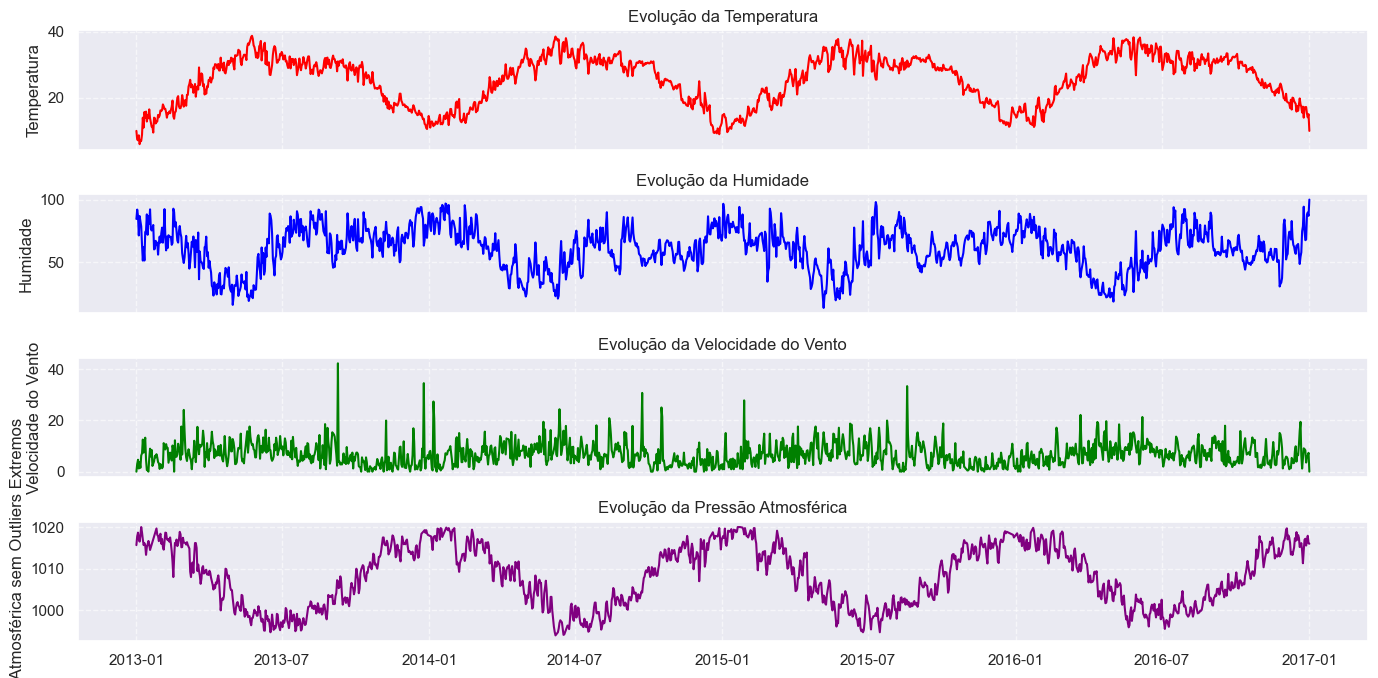

In [11]:
# Criando a figura e os subplots
fig, ax = plt.subplots(4, 1, figsize=(14, 7), sharex=True)  # 4 linhas, 1 coluna

# Gráfico de Temperatura
ax[0].plot(df_climate_train['date'], df_climate_train['meantemp'], linestyle='-', color='red')
ax[0].set_ylabel("Temperatura")
ax[0].set_title("Evolução da Temperatura")
ax[0].grid(True, linestyle="--", alpha=0.6)

# Gráfico de Humidade
ax[1].plot(df_climate_train['date'], df_climate_train['humidity'], linestyle='-', color='blue')
ax[1].set_ylabel("Humidade")
ax[1].set_title("Evolução da Humidade")
ax[1].grid(True, linestyle="--", alpha=0.6)


# Gráfico de Velocidade do Vento
ax[2].plot(df_climate_train['date'], df_climate_train['wind_speed'], linestyle='-', color='green')
ax[2].set_ylabel("Velocidade do Vento")
ax[2].set_title("Evolução da Velocidade do Vento")
ax[2].grid(True, linestyle="--", alpha=0.6)

# Gráfico de Pressão Atmosférica sem Outliers Extremos
ax[3].plot(df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['date'], df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)]['meanpressure'], linestyle='-', color='purple')
ax[3].set_ylabel("Pressão Atmosférica sem Outliers Extremos")
ax[3].set_title("Evolução da Pressão Atmosférica")
ax[3].grid(True, linestyle="--", alpha=0.6)


# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()


# <font color='green' style='font-size: 30px;'> 2.3) Como se comportam as componentes temporais da série histórica? </font>
<hr style='border: 2px solid green;'>

> 1. Trataremos as componentes através de um Modelo Aditivo

> 2. Modelos aditivos em séries temporais são um tipo de abordagem utilizada para decompor uma série temporal em componentes distintos que podem ser somados para explicar a variação nos dados ao longo do tempo. Esses componentes tipicamente incluem:

- Tendência (Trend): Representa a direção geral dos dados ao longo do tempo (por exemplo, uma tendência crescente ou decrescente).

- Sazonalidade (Seasonality): Captura padrões repetitivos que ocorrem em intervalos regulares (por exemplo, variações sazonais mensais ou anuais).

- Ciclo (Cycle): Refere-se a flutuações de longo prazo que não são devidas a sazonalidade (por exemplo, ciclos econômicos).

- Ruído (Noise): Componentes aleatórios ou erros que não são explicados pelos outros componentes.

## $$ Y_{t} = S_{t} + T{t} + R{t} $$ 

> 3. Podemos testar estacionaridade usando o Teste KPSS e o Dickey-Fuller

No KPSS o teste de hipótese se resume a:

<center>

| Nome do teste | $H_0$ (p-value > 0.05) |  $H_1$ (p-value <= 0.05) |
|---------------|------------------------|--------------------------|
| KPSS | É estacionária | Não é estacionária |

</center>

- O [teste KPSS](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html) (Kwiatkowski-Phillips-Schmidt-Shin) compara a série temporal com um modelo estacionário que tem características semelhantes à série. Ele avalia a diferença entre a série real e o modelo estacionário para determinar se a série é estacionária ou não.

- H0: É estacionário --> Não rejeitada caso p-value > 0.05

- H1: Não é estacionário --> Rejeição de H0 caso p-value <= 0.05

No ADF o teste de hipótese se resume a:

<center>

| Nome do teste | $H_0$ (p-value > 0.05) |  $H_1$ (p-value <= 0.05) |
|---------------|------------------------|--------------------------|
| ADF | Não é estacionária | É estacionária |

</center>

- O [teste de Dickey-Fuller Aumentado](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) é um teste estatístico utilizado para verificar a presença de raiz unitária em uma série temporal. Uma série temporal é considerada ter uma raiz unitária se ela não for estacionária, ou seja, se sua média e variância não forem constantes ao longo do tempo. Essa verificação acontece comparando a série temporal original com uma versão diferenciada da mesma. Ele compara a série temporal original com uma versão diferenciada da série. A diferenciação envolve subtrair cada valor da série pelo valor anterior, o que pode ajudar a remover tendências ou padrões de longo prazo na série. 

- H0: Não é estacionário --> Não rejeitada caso p-value > 0.05

- H1: É estacionário --> Rejeição de H0 caso p-value <= 0.05


> 4. Pela análise gráfica, nota-se que nenhuma das séries é estacionária, mesmo que o Teste de Hipótese afirme que sim

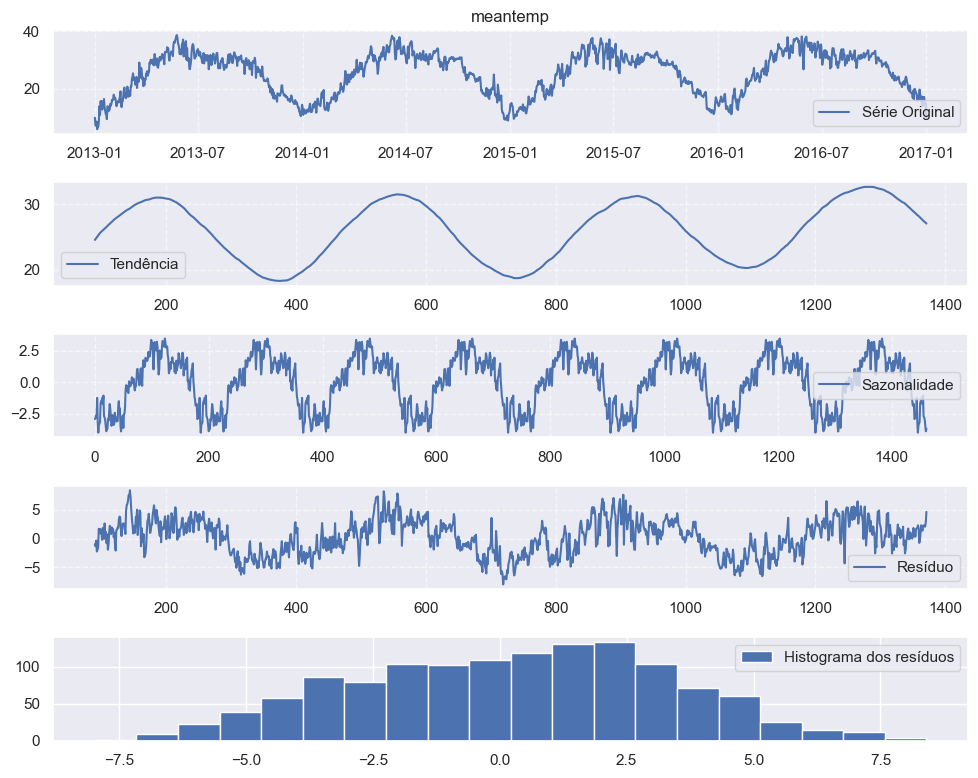

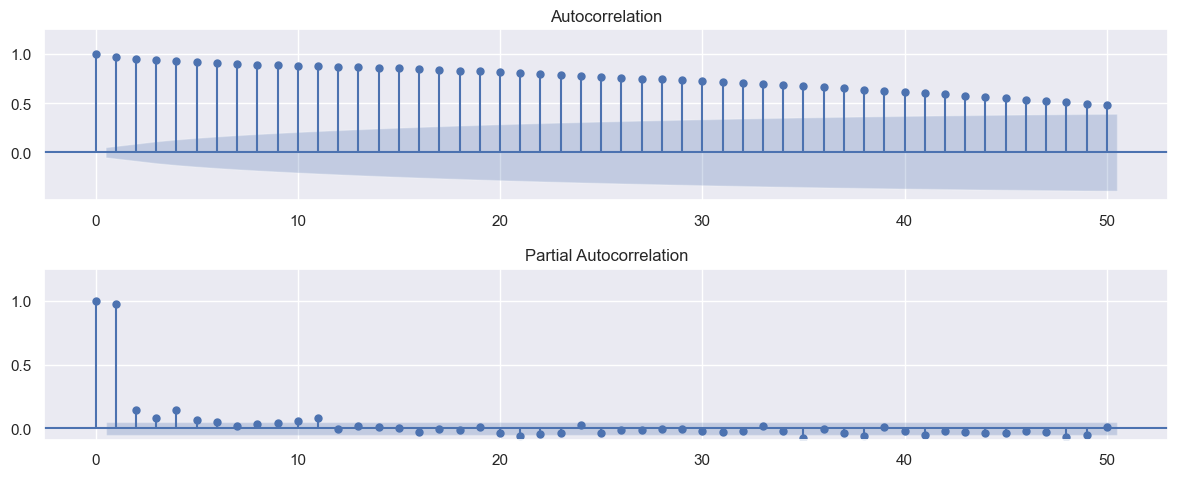

Adfuller
p-value: 0.277
Não estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




In [118]:
# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate_train['meantemp'], model='additive', period=180)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate_train['date'], df_climate_train['meantemp'], label='Série Original')
plt.title('meantemp')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(df_climate_train['meantemp'])

analisa_estacionaridade(df_climate_train['meantemp'])


# <font color='green' style='font-size: 30px;'> 2.4) Como são as distribuições das séries? </font>
<hr style='border: 2px solid green;'>

> 1. As séries não aparentam ser Distribuições Normais, ou seja, aparentemente a variância pode ser elevada e ser caótica, mostrando alta volatilidade.

> 2. Mensalmente ocorrem picos e vales, mostrando novamente que existem sazonalidades

> 3. Para corrigir isso, podemos aplicar uma Média Móvel, pois a aplicação de médias Móveis permite que a série se torne menos volátil a variações pontuais

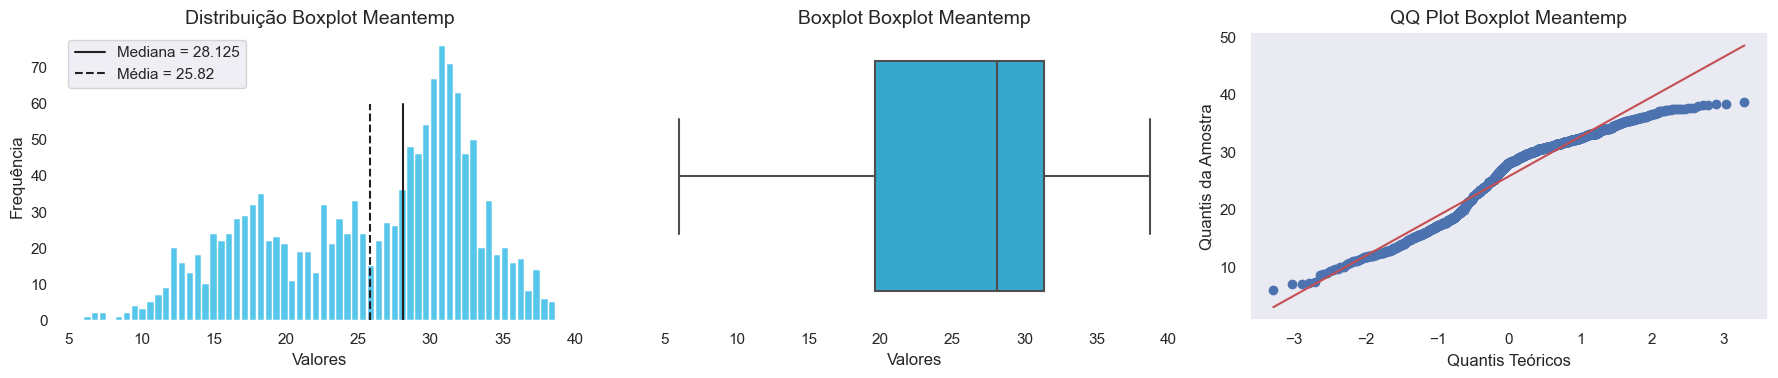

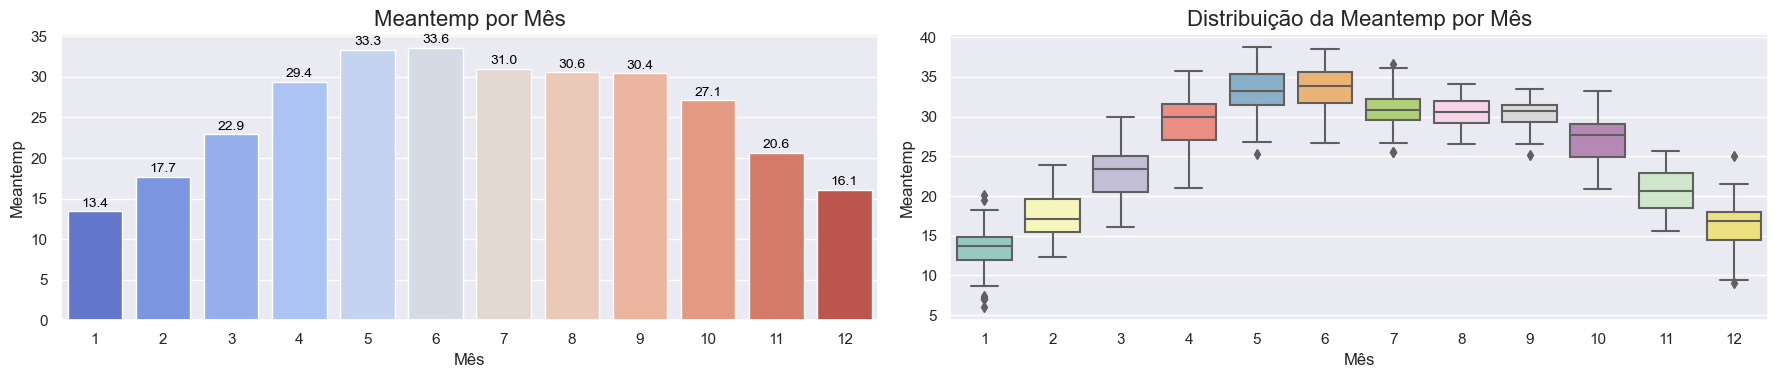

In [109]:
plota_histograma_boxplot_qq('meantemp', df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)], f'Boxplot Meantemp')
monthly_avg = df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)].groupby('month')['meantemp'].mean().reset_index()
# Criar os subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 4))

# Gráfico 1: Média por Mês
sns.barplot(
    data=monthly_avg,
    x='month',
    y='meantemp',
    palette='coolwarm',
    ax=axes[0]  #
)
axes[0].set_title(f'Meantemp por Mês', fontsize=16)
axes[0].set_xlabel('Mês', fontsize=12)
axes[0].set_ylabel(f'Meantemp', fontsize=12)

for index, row in monthly_avg.iterrows():
    axes[0].text(
        row.name, 
        row['meantemp'] + 0.2, 
        f"{row['meantemp']:.1f}", 
        ha='center', 
        va='bottom', 
        fontsize=10, 
        color='black'
    )


# Gráfico 2: Distribuição por Mês (Boxplot)
sns.boxplot(
    data=df_climate_train.loc[df_climate_train['meanpressure'].between(994, 1020)],
    x='month',
    y='meantemp',
    palette='Set3',
    ax=axes[1]  #
)
axes[1].set_title(f'Distribuição da Meantemp por Mês', fontsize=16)
axes[1].set_xlabel('Mês', fontsize=12)
axes[1].set_ylabel(f'Meantemp', fontsize=12)

# Layout final
plt.tight_layout()
plt.show()

# <font color='green' style='font-size: 30px;'> 2.5) Como fica a série diferenciada? </font>
<hr style='border: 2px solid green;'>

> 1. Quanto maior a diferenciação, mais estacionária a série parece se comportar

> 2. A Diferenciação de 2 Ordem tornou a série estacionária

> 3. Pela Queda Abrupta no ACF e pela Queda Gradual no PACF, há indícios desse modelo ser um MA

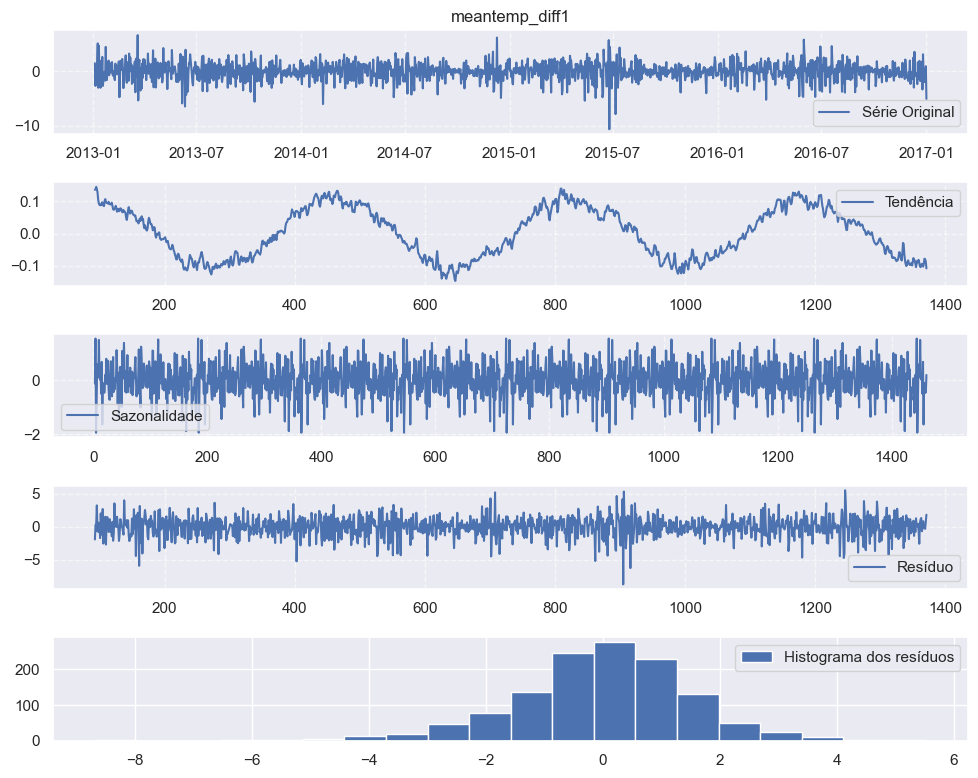

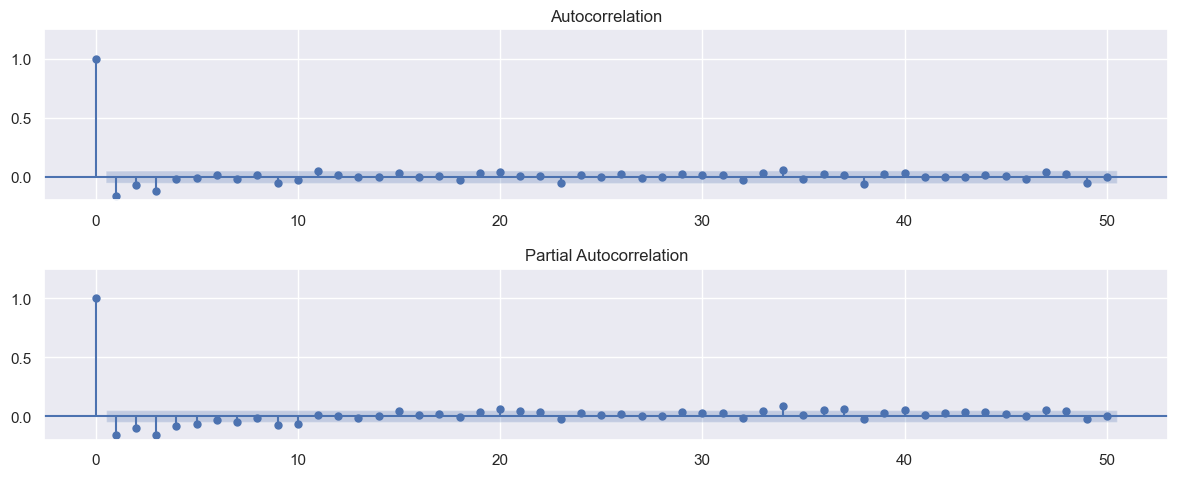

Adfuller
p-value: 0.000
Estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




In [121]:
df_climate_train['meantemp_diff1'] = df_climate_train['meantemp'].diff()
df_climate_train['meantemp_diff2'] = df_climate_train['meantemp'].diff().diff()

df_climate_train.dropna(inplace = True)

# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate_train['meantemp_diff1'], model='additive', period=180)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate_train['date'], df_climate_train['meantemp_diff1'], label='Série Original')
plt.title('meantemp_diff1')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(df_climate_train['meantemp_diff1'])

analisa_estacionaridade(df_climate_train['meantemp_diff1'])

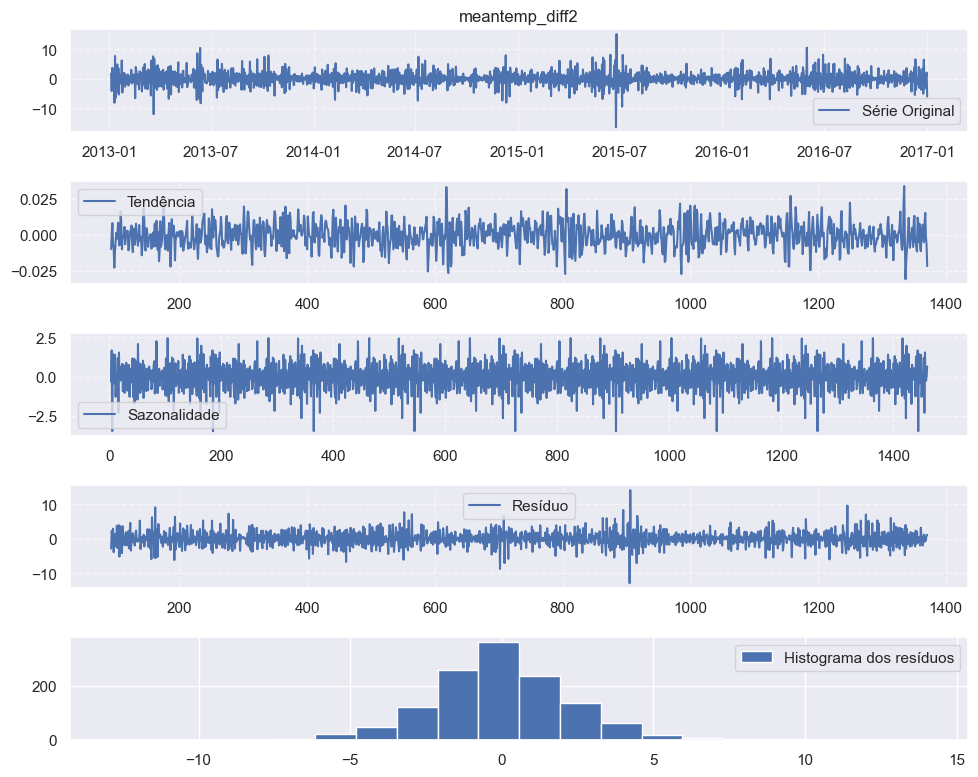

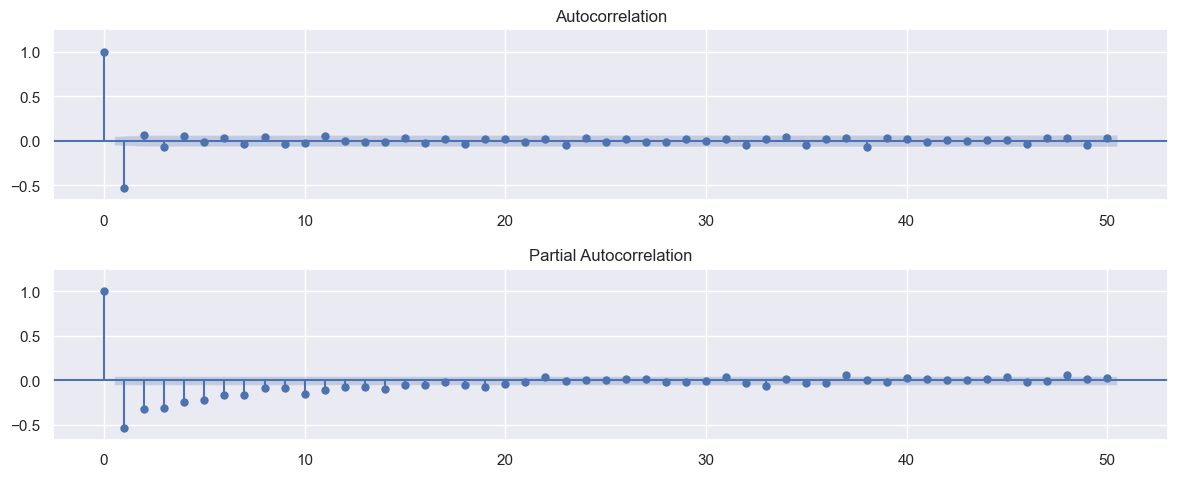

Adfuller
p-value: 0.000
Estacionária com nível de confiança de 95%


KPSS
p-value: 0.100
Estacionária com nível de confiança de 95%




In [122]:
# Realizar a decomposição da série temporal
result = seasonal_decompose(df_climate_train['meantemp_diff2'], model='additive', period=180)

# o primeiro número (5) representa o número total de linhas, e o segundo número (5) representa o índice do subplot dentro da grade. 

# Plotar os componentes decompostos
plt.figure(figsize=(10, 8))

plt.subplot(511)
plt.plot(df_climate_train['date'], df_climate_train['meantemp_diff2'], label='Série Original')
plt.title('meantemp_diff2')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(512)
plt.plot(result.trend, label='Tendência')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(513)
plt.plot(result.seasonal,label='Sazonalidade')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(514)
plt.plot(result.resid, label='Resíduo')
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.subplot(515)
plt.hist(result.resid, bins=20, label="Histograma dos resíduos")
plt.legend()

plt.tight_layout()
plt.show()

plota_acf_pacf(df_climate_train['meantemp_diff2'])

analisa_estacionaridade(df_climate_train['meantemp_diff2'])

# <font color='green' style='font-size: 30px;'> 2.6) Existe correlação entre as séries? </font>
<hr style='border: 2px solid green;'>

> 1. Existem correlações entre as séries, mesmo que fracas

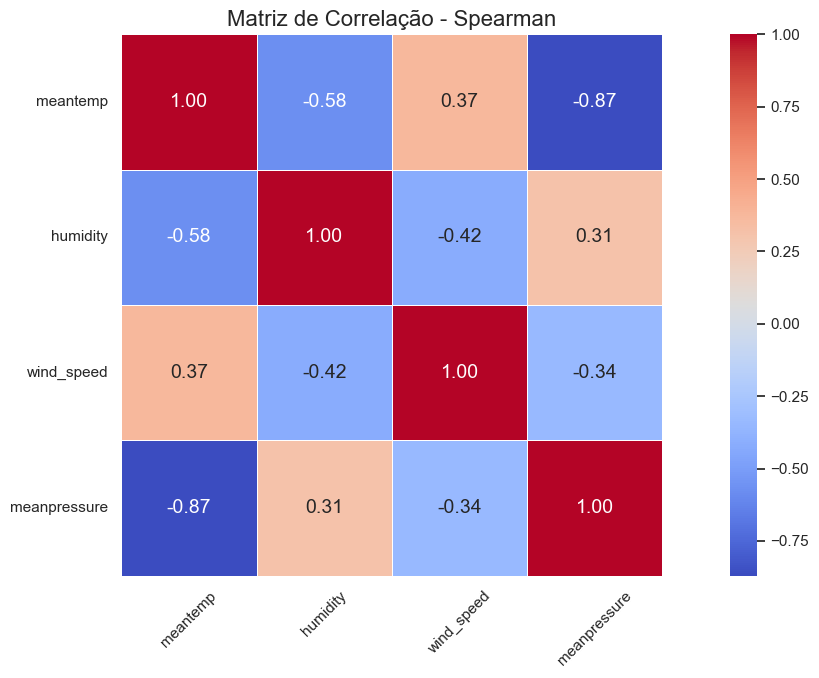

In [17]:
df_climate_train_corr = df_climate_train.drop(['month', 'year'], axis = 1).copy()
plt.figure(figsize=(14, 7))

sns.heatmap(
    df_climate_train_corr.corr(method = 'spearman'),
    annot=True,     
    cmap='coolwarm',
    fmt=".2f",      
    linewidths=0.5, 
    square=True     
)

plt.title("Matriz de Correlação - Spearman", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# <font color='red' style='font-size: 40px;'> 3) Feature Engineering </font>
<hr style='border: 2px solid red;'>

> 1. As Janelas foram escolhidas de acordo com a Diagrama ACF e PACF:

- Para as Lags, observou-se o ACF e viu-se que a Lag 1 era a mais importante, ao passo que o PACF tinha queda abrupta. Isso significa que provavelmente o Modelo será um ARIMA (0, 2, 1)

- Dessa forma, optou-se por trabalhar com Janelas de 3 dias, não se distanciando da Lag 1 do PACF e não se alogando tanto até a Lag 8 do ACF

> 2. Para modelos de árvore, é fundamental trabalharmos as variáveis num contexto temporal uma vez que elas não entendem a ordem por si só


,date,month,year,meantemp,humidity,wind_speed,meanpressure,sample,meantemp_lag_d1,meantemp_lag_d2,meantemp_lag_d3,meantemp_lag_m1,meantemp_lag_m3,meantemp_lag_m6,meantemp_media_movel_d3,meantemp_media_movel_m1,meantemp_media_movel_m3,meantemp_media_movel_m6,humidity_lag_d1,humidity_lag_d2,humidity_lag_d3,humidity_lag_m1,humidity_lag_m3,humidity_lag_m6,humidity_media_movel_d3,humidity_media_movel_m1,humidity_media_movel_m3,humidity_media_movel_m6,wind_speed_lag_d1,wind_speed_lag_d2,wind_speed_lag_d3,wind_speed_lag_m1,wind_speed_lag_m3,wind_speed_lag_m6,wind_speed_media_movel_d3,wind_speed_media_movel_m1,wind_speed_media_movel_m3,wind_speed_media_movel_m6,meanpressure_lag_d1,meanpressure_lag_d2,meanpressure_lag_d3,meanpressure_lag_m1,meanpressure_lag_m3,meanpressure_lag_m6,meanpressure_media_movel_d3,meanpressure_media_movel_m1,meanpressure_media_movel_m3,meanpressure_media_movel_m6
180,2013-06-30,6,2013,32.83,52.17,10.50,997.17,train,33.25,31.50,31.43,33.62,25.38,10.00,32.06,32.51,31.73,24.50,57.00,64.25,61.86,40.12,45.50,84.50,61.04,58.36,40.51,53.91,13.88,8.81,7.96,10.64,4.40,0.00,10.21,9.60,8.84,7.93,995.25,996.00,996.71,998.71,1008.50,1015.67,995.99,997.46,1001.24,1007.68
181,2013-07-01,7,2013,33.86,54.00,8.73,996.43,train,32.83,33.25,31.50,32.00,25.17,7.40,32.53,32.48,31.81,24.62,52.17,57.00,64.25,54.00,51.00,92.00,57.81,58.76,40.59,53.73,10.50,13.88,8.81,13.44,8.65,2.98,11.06,9.59,8.91,7.98,997.17,995.25,996.00,998.75,1009.50,1017.80,996.14,997.41,1001.11,1007.58
182,2013-07-02,7,2013,33.14,58.29,9.80,996.00,train,33.86,32.83,33.25,32.40,26.20,7.17,33.31,32.54,31.91,24.77,54.00,52.17,57.00,56.60,45.60,87.00,54.39,58.76,40.62,53.52,8.73,10.50,13.88,14.20,8.14,4.63,11.03,9.44,8.91,8.02,996.43,997.17,995.25,1001.00,1009.00,1018.67,996.28,997.33,1000.97,1007.46
183,2013-07-03,7,2013,31.57,70.00,6.36,997.57,train,33.14,33.86,32.83,35.60,24.60,8.67,33.28,32.57,31.98,24.91,58.29,54.00,52.17,47.00,41.80,71.33,54.82,58.81,40.76,53.36,9.80,8.73,10.50,12.24,11.12,1.23,9.68,9.29,8.93,8.04,996.00,996.43,997.17,999.60,1007.80,1017.17,996.53,997.16,1000.82,1007.33
184,2013-07-04,7,2013,32.38,67.50,9.25,997.00,train,31.57,33.14,33.86,35.86,25.60,6.00,32.86,32.43,32.06,25.04,70.00,58.29,54.00,42.57,31.00,86.83,60.76,59.58,41.07,53.35,6.36,9.80,8.73,5.03,15.56,3.70,8.30,9.09,8.88,8.07,997.57,996.00,996.43,999.86,1007.00,1016.50,996.67,997.10,1000.71,1007.23


,date,month,year,meantemp,humidity,wind_speed,meanpressure,sample,meantemp_lag_d1,meantemp_lag_d2,meantemp_lag_d3,meantemp_lag_m1,meantemp_lag_m3,meantemp_lag_m6,meantemp_media_movel_d3,meantemp_media_movel_m1,meantemp_media_movel_m3,meantemp_media_movel_m6,humidity_lag_d1,humidity_lag_d2,humidity_lag_d3,humidity_lag_m1,humidity_lag_m3,humidity_lag_m6,humidity_media_movel_d3,humidity_media_movel_m1,humidity_media_movel_m3,humidity_media_movel_m6,wind_speed_lag_d1,wind_speed_lag_d2,wind_speed_lag_d3,wind_speed_lag_m1,wind_speed_lag_m3,wind_speed_lag_m6,wind_speed_media_movel_d3,wind_speed_media_movel_m1,wind_speed_media_movel_m3,wind_speed_media_movel_m6,meanpressure_lag_d1,meanpressure_lag_d2,meanpressure_lag_d3,meanpressure_lag_m1,meanpressure_lag_m3,meanpressure_lag_m6,meanpressure_media_movel_d3,meanpressure_media_movel_m1,meanpressure_media_movel_m3,meanpressure_media_movel_m6
109,2017-04-20,4,2017,34.50,27.50,5.56,998.62,test,33.50,34.00,32.56,25.00,15.26,29.33,33.35,29.55,22.49,21.19,24.12,27.33,38.44,49.00,66.47,49.48,29.97,33.78,53.03,58.84,9.03,7.81,5.37,9.26,11.23,13.32,7.40,9.66,8.49,7.38,1000.88,1003.11,1004.44,1011.75,1007.75,1009.37,1002.81,1006.82,1011.20,1012.96
110,2017-04-21,4,2017,34.25,39.38,6.96,999.88,test,34.50,33.50,34.00,27.25,15.39,27.50,34.00,29.87,22.70,21.22,27.50,24.12,27.33,45.00,70.87,54.96,26.32,33.07,52.60,58.72,5.56,9.03,7.81,10.19,13.70,11.55,7.47,9.54,8.43,7.33,998.62,1000.88,1003.11,1009.75,1007.75,1009.31,1000.87,1006.38,1011.10,1012.90
111,2017-04-22,4,2017,32.90,40.90,8.89,1001.60,test,34.25,34.50,33.50,28.00,18.44,28.50,34.08,30.10,22.91,21.25,39.38,27.50,24.12,49.75,76.24,51.42,30.33,32.88,52.25,58.64,6.96,5.56,9.03,3.49,5.87,11.19,7.18,9.43,8.35,7.31,999.88,998.62,1000.88,1008.88,1007.75,1008.27,999.79,1006.05,1011.01,1012.85
112,2017-04-23,4,2017,32.88,27.50,9.96,1002.12,test,32.90,34.25,34.50,28.92,18.12,28.04,33.88,30.27,23.07,21.28,40.90,39.38,27.50,37.67,76.00,54.56,35.92,32.59,51.85,58.58,8.89,6.96,5.56,10.03,6.75,12.39,7.14,9.61,8.39,7.29,1001.60,999.88,998.62,1010.58,1019.82,1008.92,1000.03,1005.81,1010.94,1012.81
113,2017-04-24,4,2017,32.00,27.14,12.16,1004.14,test,32.88,32.90,34.25,26.50,18.35,27.58,33.34,30.40,23.24,21.30,27.50,40.90,39.38,39.38,68.13,56.19,35.92,32.25,51.32,58.43,9.96,8.89,6.96,10.43,3.39,5.70,8.60,9.61,8.42,7.28,1002.12,1001.60,999.88,1009.88,1018.87,1011.73,1001.20,1005.53,1010.75,1012.78


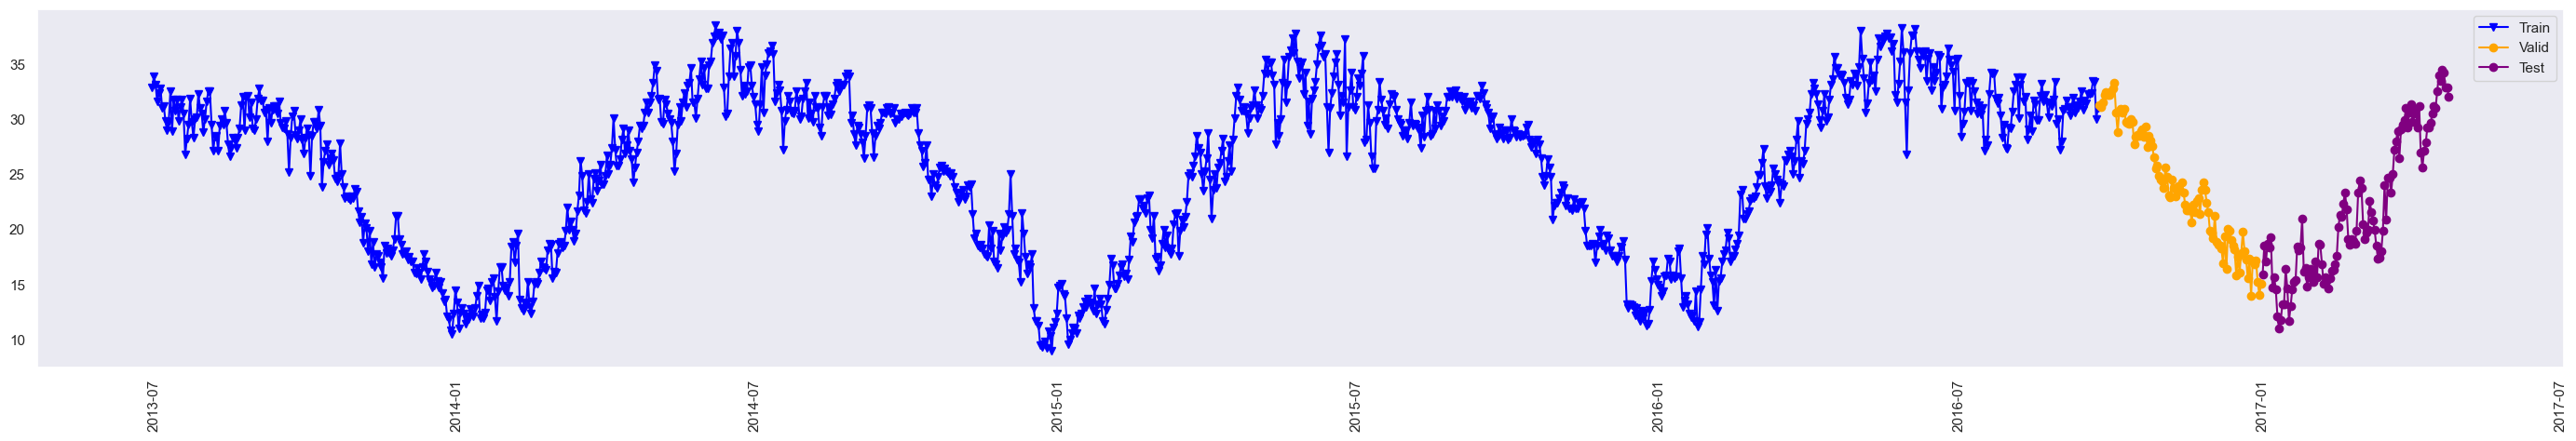

In [174]:
# Data
df_climate_train = pd.read_csv('./data/DailyDelhiClimateTrain.csv')
ano_mes_dia(df_climate_train)
df_climate_train = df_climate_train[['date', 'month', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]


df_climate_test = pd.read_csv('./data/DailyDelhiClimateTest.csv')
ano_mes_dia(df_climate_test)
df_climate_test = df_climate_test[['date', 'month', 'year', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']]

# Train-Valid-Test
df_train = df_climate_train[:-100]
df_train['sample'] = 'train'
df_valid = df_climate_train[-100:-1]
df_valid['sample'] = 'valid'
df_test = df_climate_test
df_test['sample'] = 'test'
df_model = pd.concat([df_train, df_valid, df_test], axis=0)

# Pre-Processamento
meanpreassure_imputer_train = df_train.meanpressure.median()
df_model['meanpressure'] = np.where(df_model['meanpressure'].between(994, 1020), df_model['meanpressure'], meanpreassure_imputer_train)

# Features
df_model['month'] = df_model['date'].dt.month

df_model['meantemp_lag_d1'] = df_model['meantemp'].shift(1)
df_model['meantemp_lag_d2'] = df_model['meantemp'].shift(2)
df_model['meantemp_lag_d3'] = df_model['meantemp'].shift(3)
df_model['meantemp_lag_m1'] = df_model['meantemp'].shift(30)
df_model['meantemp_lag_m3'] = df_model['meantemp'].shift(90)
df_model['meantemp_lag_m6'] = df_model['meantemp'].shift(180)
df_model['meantemp_media_movel_d3'] = df_model['meantemp'].shift(1).rolling(3).mean()
df_model['meantemp_media_movel_m1'] = df_model['meantemp'].shift(1).rolling(30).mean()
df_model['meantemp_media_movel_m3'] = df_model['meantemp'].shift(1).rolling(90).mean()
df_model['meantemp_media_movel_m6'] = df_model['meantemp'].shift(1).rolling(180).mean()

df_model['humidity_lag_d1'] = df_model['humidity'].shift(1)
df_model['humidity_lag_d2'] = df_model['humidity'].shift(2)
df_model['humidity_lag_d3'] = df_model['humidity'].shift(3)
df_model['humidity_lag_m1'] = df_model['humidity'].shift(30)
df_model['humidity_lag_m3'] = df_model['humidity'].shift(90)
df_model['humidity_lag_m6'] = df_model['humidity'].shift(180)
df_model['humidity_media_movel_d3'] = df_model['humidity'].shift(1).rolling(3).mean()
df_model['humidity_media_movel_m1'] = df_model['humidity'].shift(1).rolling(30).mean()
df_model['humidity_media_movel_m3'] = df_model['humidity'].shift(1).rolling(90).mean()
df_model['humidity_media_movel_m6'] = df_model['humidity'].shift(1).rolling(180).mean()

df_model['wind_speed_lag_d1'] = df_model['wind_speed'].shift(1)
df_model['wind_speed_lag_d2'] = df_model['wind_speed'].shift(2)
df_model['wind_speed_lag_d3'] = df_model['wind_speed'].shift(3)
df_model['wind_speed_lag_m1'] = df_model['wind_speed'].shift(30)
df_model['wind_speed_lag_m3'] = df_model['wind_speed'].shift(90)
df_model['wind_speed_lag_m6'] = df_model['wind_speed'].shift(180)
df_model['wind_speed_media_movel_d3'] = df_model['wind_speed'].shift(1).rolling(3).mean()
df_model['wind_speed_media_movel_m1'] = df_model['wind_speed'].shift(1).rolling(30).mean()
df_model['wind_speed_media_movel_m3'] = df_model['wind_speed'].shift(1).rolling(90).mean()
df_model['wind_speed_media_movel_m6'] = df_model['wind_speed'].shift(1).rolling(180).mean()

df_model['meanpressure_lag_d1'] = df_model['meanpressure'].shift(1)
df_model['meanpressure_lag_d2'] = df_model['meanpressure'].shift(2)
df_model['meanpressure_lag_d3'] = df_model['meanpressure'].shift(3)
df_model['meanpressure_lag_m1'] = df_model['meanpressure'].shift(30)
df_model['meanpressure_lag_m3'] = df_model['meanpressure'].shift(90)
df_model['meanpressure_lag_m6'] = df_model['meanpressure'].shift(180)
df_model['meanpressure_media_movel_d3'] = df_model['meanpressure'].shift(1).rolling(3).mean()
df_model['meanpressure_media_movel_m1'] = df_model['meanpressure'].shift(1).rolling(30).mean()
df_model['meanpressure_media_movel_m3'] = df_model['meanpressure'].shift(1).rolling(90).mean()
df_model['meanpressure_media_movel_m6'] = df_model['meanpressure'].shift(1).rolling(180).mean()

df_model = df_model.dropna().copy()

display(df_model.head())
display(df_model.tail())

plt.figure(figsize=(35,5))
plt.grid()

plt.plot(df_model.loc[df_model['sample'] == 'train']['date'], 
         df_model.loc[df_model['sample'] == 'train']['meantemp'], 
         marker='v', label='Train', color = 'blue')

plt.plot(df_model.loc[df_model['sample'] == 'valid']['date'], 
         df_model.loc[df_model['sample'] == 'valid']['meantemp'], 
         marker='o', label='Valid', color = 'orange')

plt.plot(df_model.loc[df_model['sample'] == 'test']['date'], 
         df_model.loc[df_model['sample'] == 'test']['meantemp'], 
         marker='o', label='Test', color = 'purple')

plt.xticks(rotation=90)
plt.legend()
plt.show()


# <font color='red' style='font-size: 40px;'> 4) Modelagem </font>
<hr style='border: 2px solid red;'>

### Testar:

> 1. ARIMA

> 2. SARIMA

> 3. Random Forest

> 4. LightGBM


# <font color='green' style='font-size: 30px;'> 4.1) Modelos Estatísticos - ARIMAX e SARIMAX </font>
<hr style='border: 2px solid green;'>

> 1. O ARIMAX e o SARIMAX podem ser implementados usando o Statsmodels e o PMD

- O Statsmodels demanda que o cientista decida as ordens de cada parâmetro ao passo que o PMD possui um otimizador para escolher a melhor opção

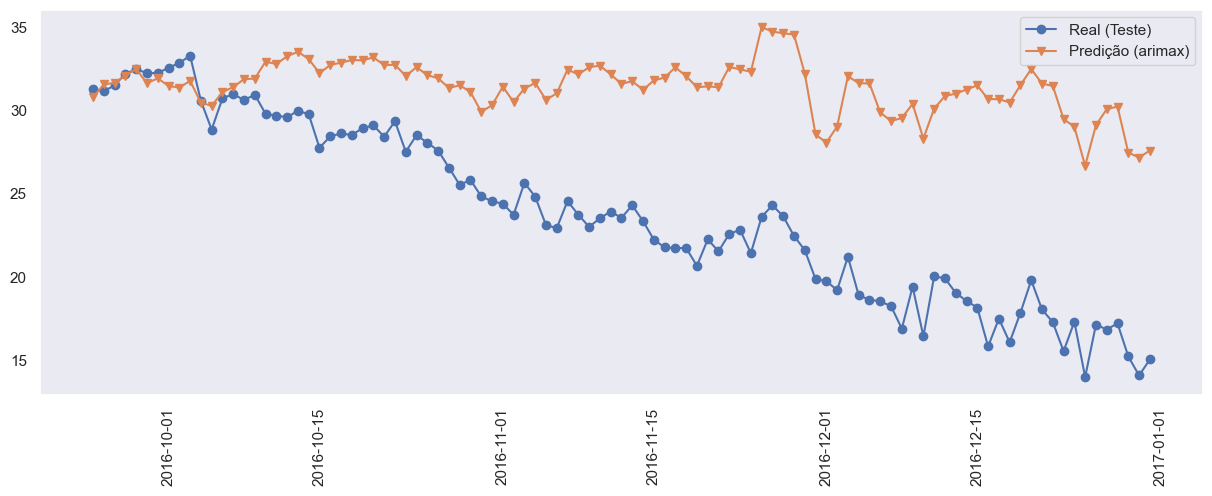

AIC do modelo: 3881.8975323415407


,MAE,RMSE,MAPE,modelo
1,7.68,8.85,0.25,ARIMAX


In [198]:
df_model_train = df_model.loc[df_model['sample'] == 'train']
df_model_valid = df_model.loc[df_model['sample'] == 'valid']
df_model_test = df_model.loc[df_model['sample'] == 'test']

arimax_statsmodel = ARIMA(
    df_model_train['meantemp'], 
    exog=df_model_train[['humidity', 'wind_speed','meanpressure']], 
    order=(0, 2, 1), # p=1 last day influence today and q=1, d=1 for removing this slightly trend
)
arimax_statsmodel = arimax_statsmodel.fit()

start = len(df_model_train)
end = start + len(df_model_valid) - 1

arimax_statsmodel_pred = arimax_statsmodel.predict(
    start=start,
    end=end,
    exog=df_model_valid[['humidity', 'wind_speed', 'meanpressure']]
)


# Plotando as previsões
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(df_model_valid['date'], df_model_valid['meantemp'], marker='o', label='Real (Teste)')
plt.plot(df_model_valid['date'], arimax_statsmodel_pred, marker='v', label='Predição (arimax)')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# AIC e avaliação
print("AIC do modelo:", arimax_statsmodel.aic)
metricas('ARIMAX', df_model_valid['meantemp'], arimax_statsmodel_pred)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=4683.772, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=4467.893, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=4681.772, Time=0.30 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=4359.786, Time=0.21 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=4233.676, Time=0.26 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=4154.151, Time=0.34 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=4089.014, Time=0.38 sec
 ARIMA(5,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=4.18 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.75 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=4087.015, Time=0.33 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=4152.152, Time=0.31 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=inf, Time=1.73 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=inf, Time=1.28 s

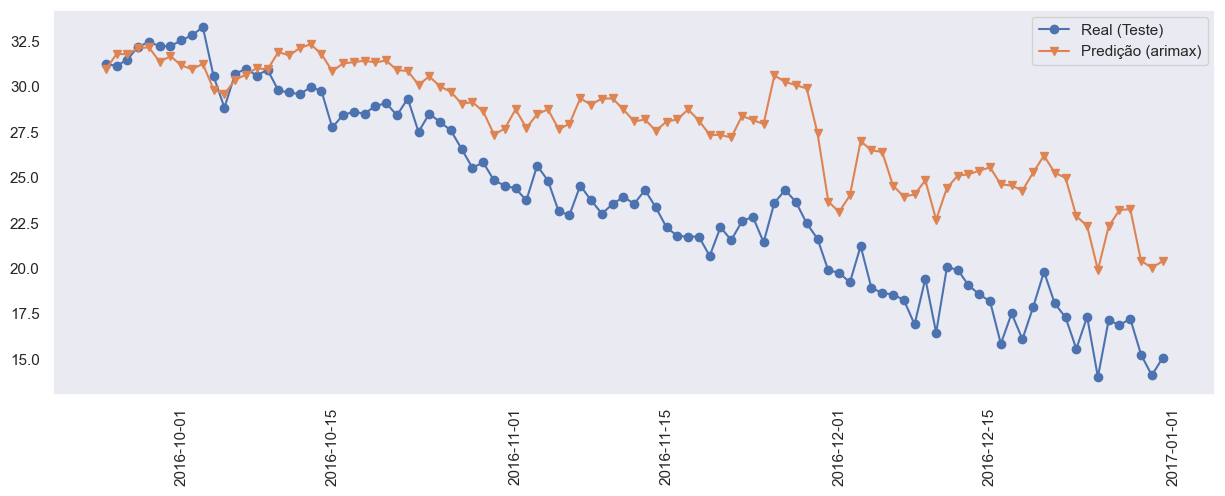

AIC value: 4087.0152712965128


,MAE,RMSE,MAPE,modelo
1,4.26,4.84,0.16,ARIMAX


In [194]:
# Ajuste de arimax simples (sem sazonalidade)
arimax = pm.auto_arima(
    df_model_train['meantemp'],  # Série dependente
    X=df_model_train[['humidity', 'wind_speed','meanpressure']],  # Variáveis exógenas
    d=2,  # Diferenciação não-sazonal
    seasonal=False,  # Desliga a sazonalidade (modelo arimax puro)
    error_action='ignore',  # Ignora erros durante o ajuste
    trace=True,  # Mostra os modelos testados
    suppress_warnings=True,  # Oculta warnings
    maxiter=500,  # Máximo de iterações
    test='adf'  # Usa ADF para escolher o valor ótimo de 'd'
)

# Exibe sumário e parâmetros do modelo ajustado
print(arimax.summary())
print(arimax.params())

# Gera previsões para o mesmo número de períodos do teste
pred = arimax.predict(
    n_periods=len(df_model_valid),
    X=df_model_valid[['humidity', 'wind_speed','meanpressure']],  # Regressoras exógenas futuras
    alpha=0.05  # Intervalo de confiança
)

# Plotando as previsões
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(df_model_valid['date'], df_model_valid['meantemp'], marker='o', label='Real (Teste)')
plt.plot(df_model_valid['date'], pred, marker='v', label='Predição (arimax)')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# AIC e avaliação
print("AIC value: {}".format(arimax.aic()))
metricas('ARIMAX', df_model_valid['meantemp'], pred)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=3791.436, Time=6.28 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=3877.098, Time=0.13 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=3880.137, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=3880.179, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=3875.098, Time=0.19 sec
 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=3792.605, Time=1.32 sec
 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=3792.597, Time=1.53 sec
 ARIMA(2,1,2)(2,0,1)[6] intercept   : AIC=3796.163, Time=2.86 sec
 ARIMA(2,1,2)(1,0,2)[6] intercept   : AIC=3796.201, Time=2.72 sec
 ARIMA(2,1,2)(0,0,0)[6] intercept   : AIC=3790.722, Time=0.74 sec
 ARIMA(1,1,2)(0,0,0)[6] intercept   : AIC=3796.226, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[6] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(3,1,2)(0,0,0)[6] intercept   : AIC=3790.290, Time=0.47 sec
 ARIMA(3,1,2)(1,0,0)[6] intercept   : AIC=3792.289, Time=0.83 sec
 ARIMA(3,1,2)(0,0,1)[6] intercept   : 

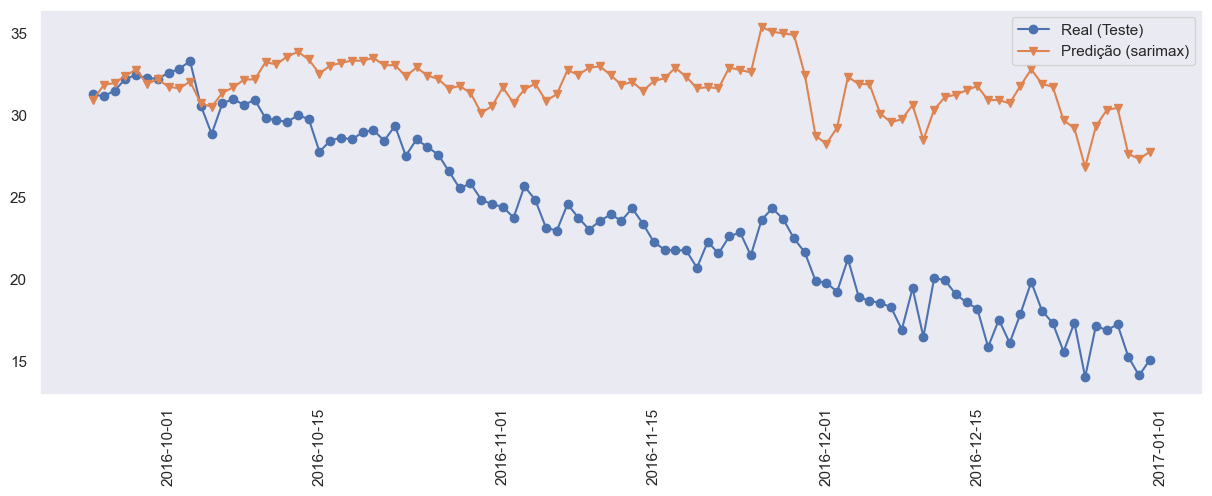

AIC value: 3787.6674504972034


,MAE,RMSE,MAPE,modelo
1,7.91,9.07,0.25,SARIMAX


In [213]:
# Ajuste de sarimax simples (sem sazonalidade)
# sarimax = pm.auto_arima(
#     df_model_train['meantemp'],  # Série temporal principal (variável dependente)
#     X= df_model_train[['humidity', 'wind_speed','meanpressure']],  # Variáveis exógenas (modelo SARIMAX)
#     d=2,  # Ordem de diferenciação não sazonal (número de vezes que a série será diferenciada para ficar estacionária)
#     error_action='ignore',  # Ignora erros durante o ajuste de modelos e continua tentando
#     trace=True,  # Exibe no console os modelos testados e seus critérios de performance (AIC, BIC, etc.)
#     suppress_warnings=True,  # Suprime avisos para manter o output limpo
#     maxiter=500,  # Número máximo de iterações para otimizar os parâmetros
#     m=4,  # Período sazonal. Neste caso, 4 períodos por ciclo (ex: sazonalidade trimestral)
#     stationary=False,  # Indica que a série original **não é** estacionária
#     test='adf'  # Teste usado para verificar estacionariedade e determinar `d`. Aqui é o ADF (Augmented Dickey-Fuller)
# )

sarimax = pm.auto_arima(
    df_model_train['meantemp'],
    X=df_model_train[['humidity', 'wind_speed', 'meanpressure']],
    seasonal=True,
    m=6,
    error_action='ignore',
    trace=True,
    maxiter=500,
    suppress_warnings=True
)


# Exibe sumário e parâmetros do modelo ajustado
print(sarimax.summary())
print(sarimax.params())

# Gera previsões para o mesmo número de períodos do teste
pred = sarimax.predict(
    n_periods=len(df_model_valid),
    X= df_model_valid[['humidity', 'wind_speed','meanpressure']],  # Regressoras exógenas futuras
    alpha=0.05  # Intervalo de confiança
)

# Plotando as previsões
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(df_model_valid['date'], df_model_valid['meantemp'], marker='o', label='Real (Teste)')
plt.plot(df_model_valid['date'], pred, marker='v', label='Predição (sarimax)')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# AIC e avaliação
print("AIC value: {}".format(sarimax.aic()))
metricas('SARIMAX', df_model_valid['meantemp'], pred)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3791.647, Time=4.94 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3877.098, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3879.861, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3879.916, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3875.098, Time=0.19 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3792.281, Time=1.92 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=3792.241, Time=2.38 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=3792.382, Time=19.37 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3792.276, Time=16.26 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=3790.722, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=3796.226, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=3790.290, Time=0.43 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=3791.930, Time=1.27 sec
 ARIMA(3,1,2)(0,0,1)[1

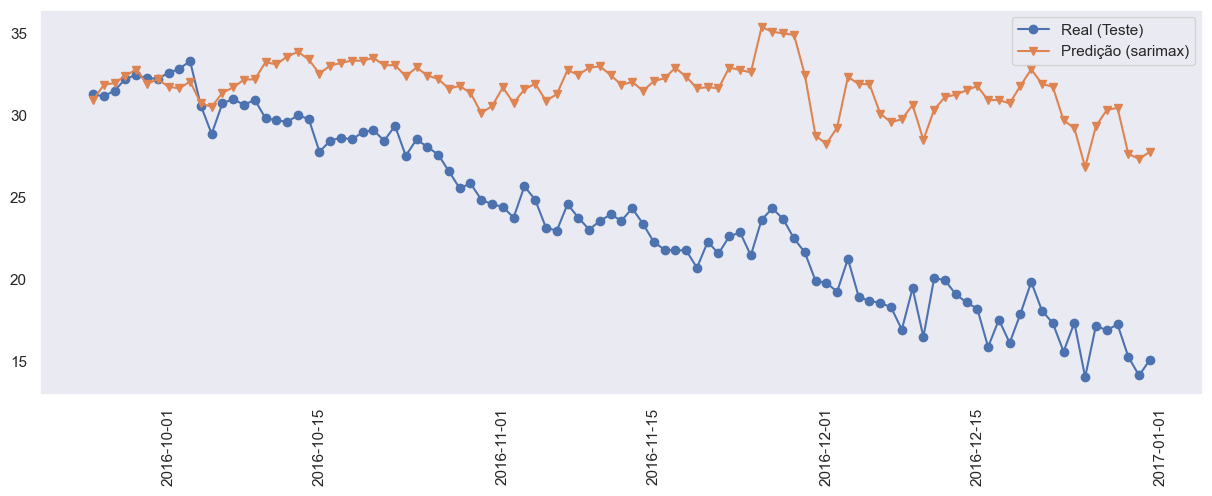

AIC value: 3787.6674504972034


,MAE,RMSE,MAPE,modelo
1,7.91,9.07,0.25,SARIMAX


In [219]:
# Ajuste de sarimax simples (sem sazonalidade)
# sarimax = pm.auto_arima(
#     df_model_train['meantemp'],  # Série temporal principal (variável dependente)
#     X= df_model_train[['humidity', 'wind_speed','meanpressure']],  # Variáveis exógenas (modelo SARIMAX)
#     d=2,  # Ordem de diferenciação não sazonal (número de vezes que a série será diferenciada para ficar estacionária)
#     error_action='ignore',  # Ignora erros durante o ajuste de modelos e continua tentando
#     trace=True,  # Exibe no console os modelos testados e seus critérios de performance (AIC, BIC, etc.)
#     suppress_warnings=True,  # Suprime avisos para manter o output limpo
#     maxiter=500,  # Número máximo de iterações para otimizar os parâmetros
#     m=4,  # Período sazonal. Neste caso, 4 períodos por ciclo (ex: sazonalidade trimestral)
#     stationary=False,  # Indica que a série original **não é** estacionária
#     test='adf'  # Teste usado para verificar estacionariedade e determinar `d`. Aqui é o ADF (Augmented Dickey-Fuller)
# )

sarimax = pm.auto_arima(
    df_model_train['meantemp'],
    X=df_model_train[['humidity', 'wind_speed', 'meanpressure']],
    seasonal=True,
    m=12,
    error_action='ignore',
    trace=True,
    maxiter=500,
    suppress_warnings=True
)


# Exibe sumário e parâmetros do modelo ajustado
print(sarimax.summary())
print(sarimax.params())

# Gera previsões para o mesmo número de períodos do teste
pred = sarimax.predict(
    n_periods=len(df_model_valid),
    X= df_model_valid[['humidity', 'wind_speed','meanpressure']],  # Regressoras exógenas futuras
    alpha=0.05  # Intervalo de confiança
)

# Plotando as previsões
plt.figure(figsize=(15, 5))
plt.grid()
plt.plot(df_model_valid['date'], df_model_valid['meantemp'], marker='o', label='Real (Teste)')
plt.plot(df_model_valid['date'], pred, marker='v', label='Predição (sarimax)')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# AIC e avaliação
print("AIC value: {}".format(sarimax.aic()))
metricas('SARIMAX', df_model_valid['meantemp'], pred)


# <font color='green' style='font-size: 30px;'> 4.2) Modelos de Machine Learning - Random Forest e LightGBM </font>
<hr style='border: 2px solid green;'>

> 1. Não Requerem premissas